<font size=6><b>Определение стоимости автомобилей</b></font>

---

<font size=5><b>Описание проекта</b></font>

<div style="border:solid darkcyan 2px; padding: 20px; border-radius: 10px">
    
<b>Цель</b>: Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. Необходимо построить модель, которая умеет её определять. Критерии, которые важны заказчику: качество предсказания, время обучения модели, время предсказания модели.<br><br>
<b>Данные</b>: Набор данных находится в файле */datasets/autos.csv*. Данные о технических характеристиках, комплектации и ценах других автомобилей. Целевой признак: цена автомобиля (евро).<br><br>
<b>Содержание</b>:   
1. Загрузка данных.  
1. Изучение данных.  
1. Подготовка выборок для обучения.  
1. Обучение моделей.  
1. Анализ моделей.  
1. Проверка лучшей модели.  
1. Выводы.

## 1. Загрузка данных

In [1]:
import numpy as np
import pandas as pd
import phik
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from IPython.display import clear_output
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

RSTATE = 10101
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('autos.csv')

In [3]:
display(f'Размеры датасета: {df.shape}')
display(df.info())
display(df.head())

'Размеры датасета: (354369, 16)'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<div style="border:solid darkcyan 2px; padding: 20px; border-radius: 10px">

Набор данных содержит 354369 объектов по 16 признаков. В данных есть пропуски. Типы: int и object.

## 2. Изучение данных

In [4]:
df1 = df.copy()

Преобразуем даты в формат даты для дальнейшего изучения.

In [5]:
df1['DateCrawled'] = pd.to_datetime(df1['DateCrawled'])#.astype(np.int64)
df1['DateCreated'] = pd.to_datetime(df1['DateCreated'])#.astype(np.int64)
df1['LastSeen'] = pd.to_datetime(df1['LastSeen'])#.astype(np.int64)

Рассмотрим, какие года и месяцы присутствуют в датах.

In [6]:
print(f'DateCrawled: годы {df1["DateCrawled"].dt.year.unique()}, месяцы {df1["DateCrawled"].dt.month.unique()}')
print(f'DateCreated: годы {df1["DateCreated"].dt.year.unique()}, месяцы {df1["DateCreated"].dt.month.unique()}')
print(f'LastSeen: годы {df1["LastSeen"].dt.year.unique()}, месяцы {df1["LastSeen"].dt.month.unique()}')

DateCrawled: годы [2016], месяцы [3 4]
DateCreated: годы [2016 2015 2014], месяцы [ 3  4  2  1 11 12  9  8  6]
LastSeen: годы [2016], месяцы [4 3]


<div style="border:solid darkcyan 2px; padding: 20px; border-radius: 10px">

Выделим, как отдельные признаки: 
* месяц (3, 4) для **DateCrawled** и **LastSeen**;
* год (2014, 2015, 2016) для **DateCreated**.

А сами даты удалим.

In [7]:
df1['Year_Created'] = df1['DateCreated'].dt.year
df1['Month_Created'] = df1['DateCreated'].dt.month
df1['Month_LastSeen'] = df1['LastSeen'].dt.month
df1['Month_Crawled'] = df1['DateCrawled'].dt.month

df1 = df1.drop(['DateCreated', 'LastSeen', 'DateCrawled'], axis=1)

Построим матрицу корреляции.

In [8]:
phik.phik_matrix(df1).style.background_gradient(cmap='YlOrRd')

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode', 'Year_Created', 'Month_Created', 'Month_LastSeen', 'Month_Crawled']


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode,Year_Created,Month_Created,Month_LastSeen,Month_Crawled
Price,1.000000,0.268157,0.013889,0.323641,0.005752,0.579008,0.310844,0.185749,0.257367,0.355422,0.380373,0.096271,0.006540,0.021544,0.197850,0.021446
VehicleType,0.268157,1.000000,nan,0.289237,0.011764,0.917251,0.172152,0.074611,0.330157,0.633333,0.084344,0.065352,0.005570,0.022190,0.082452,0.033632
RegistrationYear,0.013889,nan,1.000000,0.003470,0.088713,0.083360,0.230438,0.031014,0.040116,0.051203,0.010072,0.000000,0.000000,0.000000,0.003929,0.000000
Gearbox,0.323641,0.289237,0.003470,1.000000,0.010497,0.647244,0.016474,0.047203,0.151407,0.520822,0.043662,0.090843,0.006014,0.008652,0.034163,0.000000
Power,0.005752,0.011764,0.088713,0.010497,1.000000,0.000000,0.000000,0.003228,0.010882,0.004458,0.011677,0.000000,0.000000,0.000000,0.000000,0.000000
Model,0.579008,0.917251,0.083360,0.647244,0.000000,1.000000,0.443418,0.150216,0.554911,0.998376,0.159132,0.221397,0.074471,0.089344,0.100254,0.017499
Kilometer,0.310844,0.172152,0.230438,0.016474,0.000000,0.443418,1.000000,0.056838,0.149136,0.275083,0.112929,0.038909,0.007016,0.015004,0.072037,0.005873
RegistrationMonth,0.185749,0.074611,0.031014,0.047203,0.003228,0.150216,0.056838,1.000000,0.057718,0.109372,0.138240,0.050177,0.000000,0.015546,0.027440,0.024769
FuelType,0.257367,0.330157,0.040116,0.151407,0.010882,0.554911,0.149136,0.057718,1.000000,0.322331,0.044514,0.050108,0.000000,0.005019,0.015675,0.007715
Brand,0.355422,0.633333,0.051203,0.520822,0.004458,0.998376,0.275083,0.109372,0.322331,1.000000,0.105511,0.181280,0.027866,0.027368,0.058172,0.002584


### 2.1 Удаление неинформативных признаков

<div style="border:solid darkcyan 2px; padding: 20px; border-radius: 10px">

Признак **NumberOfPictures** содержит только нули, поэтому удалим его.

Все даты и признаки на их основе сильно коррелируют между собой и не несут полезной информации, поэтому удалим их.

Также удалим **PostalCode**: этот признак не несёт важной информации и слабо коррелирует с целевым признаком.

In [9]:
df1 = df1.drop(['RegistrationYear', 
                'RegistrationMonth', 
                'Year_Created', 
                'Month_Created', 
                'Month_LastSeen', 
                'Month_Crawled',
                'NumberOfPictures',
                'PostalCode'
               ], 
               axis=1
              )

### 2.2 Обработка пропусков

In [10]:
print(f'Доля пропусков по признакам(%):\n{(df1.isna().sum() / len(df1) * 100).round(2).sort_values(ascending=False)}')

Доля пропусков по признакам(%):
Repaired       20.08
VehicleType    10.58
FuelType        9.28
Gearbox         5.60
Model           5.56
Price           0.00
Power           0.00
Kilometer       0.00
Brand           0.00
dtype: float64


Пропуски обнаружены в признаках: Repaired, VehicleType, FuelType, Gearbox, Model.<br>

Создадим числовой бинарный признак `Repaired_bin` и исследуем его корреляцию с другими признаками.

In [11]:
df1['Repaired_bin'] = df1['Repaired'].map({'yes': 1, 'no': 0})
print(df1.corr(numeric_only=True)['Repaired_bin'])
df1 = df1.drop('Repaired_bin', axis=1)

Price          -0.242167
Power          -0.031302
Kilometer       0.087478
Repaired_bin    1.000000
Name: Repaired_bin, dtype: float64


<div style="border:solid darkcyan 2px; padding: 20px; border-radius: 10px">

Так как пропусков много и признак `Repaired` важен, то попробуем заполнить их, исходя из других признаков `Brand` & `Model` & `VehicleType` etc.

In [12]:
# функция возвращает самое частое значение типа коробки передач для данного типа объектов
# проверка на тип и модель автомобиля
def get_filling(row, grouped):
    if row['Model'] in grouped[row['Brand']]:
        if row['VehicleType'] in grouped[row['Brand']][row['Model']]:
            return grouped[row['Brand']][row['Model']][row['VehicleType']].idxmax()
        else:
            return grouped[row['Brand']][row['Model']].idxmax()[-1]
    else:
        return grouped[row['Brand']].idxmax()[-1]

# vehicle type filling
def get_filling1(row, grouped):
    if row['Model'] in grouped[row['Brand']]:
        return grouped[row['Brand']][row['Model']].idxmax()
    else:
        return grouped[row['Brand']].idxmax()[-1]

# model filling
def get_filling2(row, grouped):
    if row['VehicleType'] in grouped[row['Brand']]:
        if row['FuelType'] in grouped[row['Brand']][row['VehicleType']]:
            return grouped[row['Brand']][row['VehicleType']][row['FuelType']].idxmax()
        else:
            return grouped[row['Brand']][row['VehicleType']].idxmax()[-1]
    else:
        return grouped[row['Brand']].idxmax()[-1]

Заполним пропуски (кроме бренда "sonstige_autos" - там много пропусков в других признаках).

In [13]:
# Ремонт
repaired_group = df.groupby(['Brand', 'Model', 'VehicleType'])['Repaired'].value_counts()
# заполнение пропусков
repaired_na_mask = (df1['Repaired'].isna()) & (df1['Brand'] != 'sonstige_autos')
df1.loc[repaired_na_mask, 'Repaired'] = df1[repaired_na_mask].apply(get_filling, grouped=repaired_group, axis=1)
print(f'Repaired: было заполнено {df["Repaired"].isna().sum() - df1["Repaired"].isna().sum()} пропущенных значений.')

# Тип коробки передач
gearbox_group = df.groupby(['Brand', 'Model', 'VehicleType'])['Gearbox'].value_counts()
# заполнение пропусков
gearbox_na_mask = (df1['Gearbox'].isna()) & (df1['Brand'] != 'sonstige_autos')
df1.loc[gearbox_na_mask, 'Gearbox'] = df1[gearbox_na_mask].apply(get_filling, grouped=gearbox_group, axis=1)
print(f'Gearbox: было заполнено {df["Gearbox"].isna().sum() - df1["Gearbox"].isna().sum()} пропущенных значений.')

# Тип топлива
fueltype_group = df.groupby(['Brand', 'Model', 'VehicleType'])['FuelType'].value_counts()
# заполнение пропусков
fueltype_na_mask = (df1['FuelType'].isna()) & (df1['Brand'] != 'sonstige_autos')
df1.loc[fueltype_na_mask, 'FuelType'] = df1[fueltype_na_mask].apply(get_filling, grouped=fueltype_group, axis=1)
print(f'FuelType: было заполнено {df["FuelType"].isna().sum() - df1["FuelType"].isna().sum()} пропущенных значений.')

# Тип автомобиля
vehicletype_group = df.groupby(['Brand', 'Model'])['VehicleType'].value_counts()
# заполнение пропусков
vehicletype_na_mask = (df1['VehicleType'].isna()) & (df1['Brand'] != 'sonstige_autos')
df1.loc[vehicletype_na_mask, 'VehicleType'] = df1[vehicletype_na_mask].apply(get_filling1, grouped=vehicletype_group, axis=1)
print(f'VehicleType: было заполнено {df["VehicleType"].isna().sum() - df1["VehicleType"].isna().sum()} пропущенных значений.')

# модель автомобиля
model_group = df.groupby(['Brand', 'VehicleType', 'FuelType'])['Model'].value_counts()
# заполнение пропусков
model_na_mask = (df1['Model'].isna()) & (df1['Brand'] != 'sonstige_autos')
df1.loc[model_na_mask, 'Model'] = df1[model_na_mask].apply(get_filling2, grouped=model_group, axis=1)
print(f'Model: было заполнено {df["Model"].isna().sum() - df1["Model"].isna().sum()} пропущенных значений.')

Repaired: было заполнено 69831 пропущенных значений.
Gearbox: было заполнено 18730 пропущенных значений.
FuelType: было заполнено 31791 пропущенных значений.
VehicleType: было заполнено 36449 пропущенных значений.
Model: было заполнено 16331 пропущенных значений.


Удалим оставшиеся пропуски.

In [14]:
df1 = df1.dropna()
print(f'Итоговое количество пропусков: {df1.isna().sum().sum()}')
print(f'Доля удалённых объектов с пропусками: {(df.shape[0] - df1.shape[0]) / df.shape[0]:.1%}')

Итоговое количество пропусков: 0
Доля удалённых объектов с пропусками: 1.0%


### 2.3 Обработка аномалий

In [15]:
df1.describe()

,Price,Power,Kilometer
count,350995.000000,350995.000000,350995.000000
mean,4410.798795,110.267585,128574.310175
std,4503.345959,189.080453,37470.436390
min,0.000000,0.000000,5000.000000
25%,1099.000000,69.000000,125000.000000
50%,2700.000000,105.000000,150000.000000
75%,6399.000000,142.000000,150000.000000
max,20000.000000,20000.000000,150000.000000


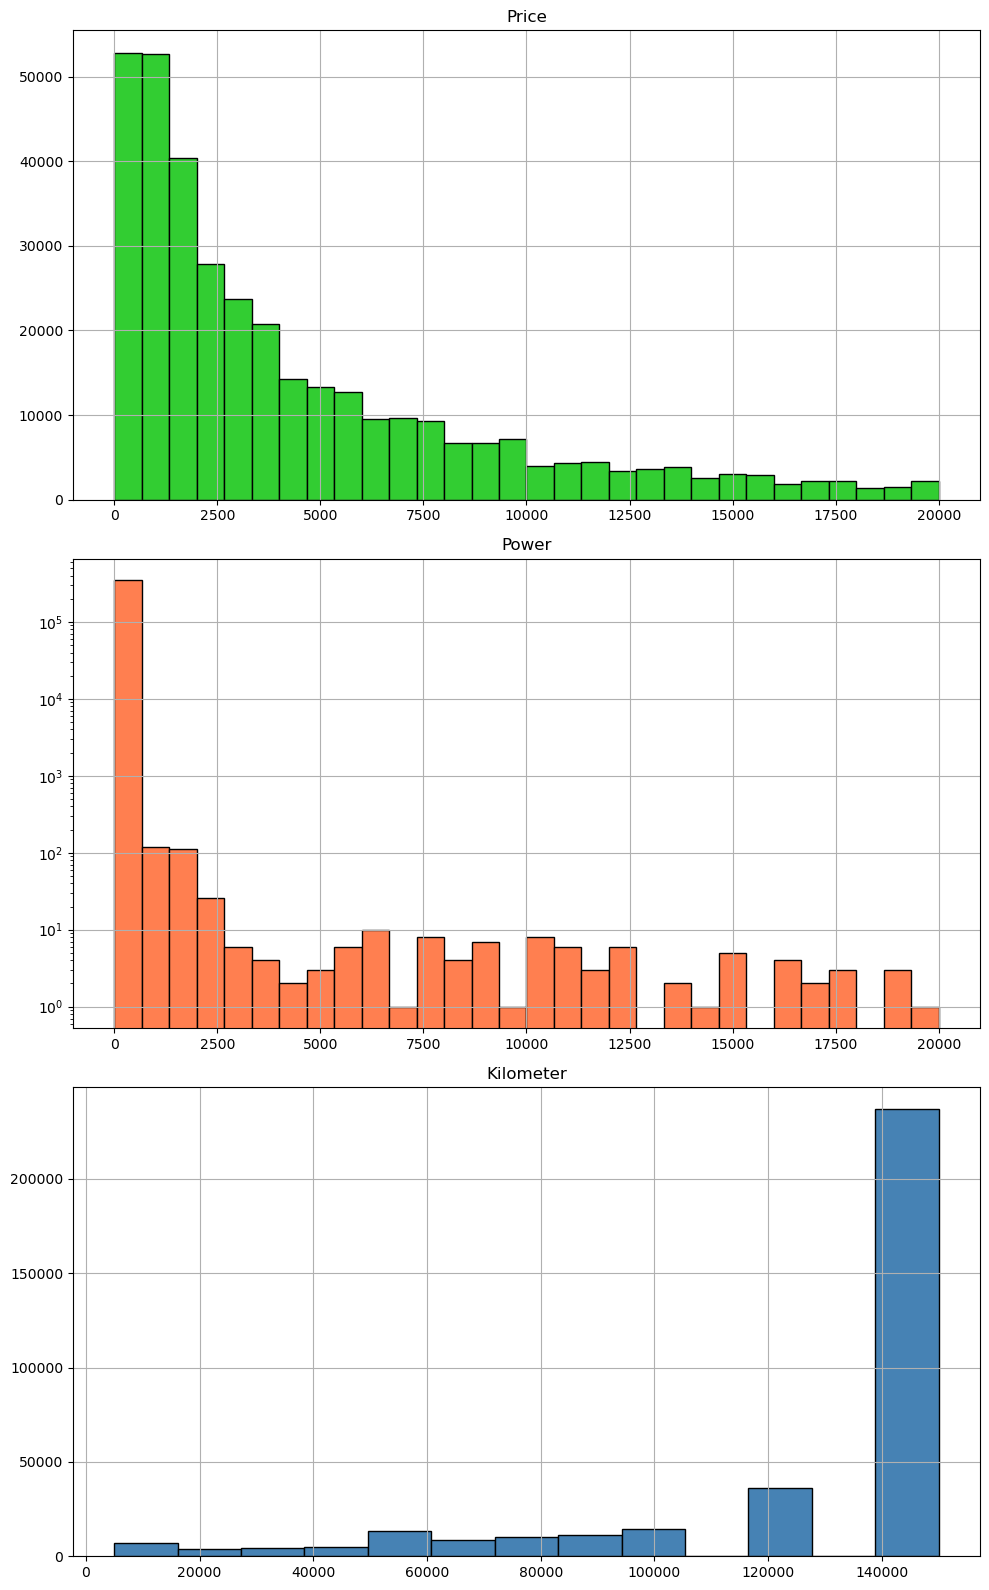

In [16]:
numeric_columns = df1.select_dtypes(int).columns
col_bins = [30, 30, 13]
col_color = ['limegreen', 'coral', 'steelblue']
is_log = [False, True, False]
fig, axes = plt.subplots(nrows=len(numeric_columns), ncols=1, figsize=(10, 16))
for i, ax in enumerate(axes):
    df1[numeric_columns[i]].hist(bins=col_bins[i], color=col_color[i], log=is_log[i], edgecolor='black', ax=ax)
    ax.set_title(numeric_columns[i])
plt.tight_layout()
plt.show()

#### 2.3.1 Power

Количество объектов со слишком большой мощностью двигателя: 0.08%


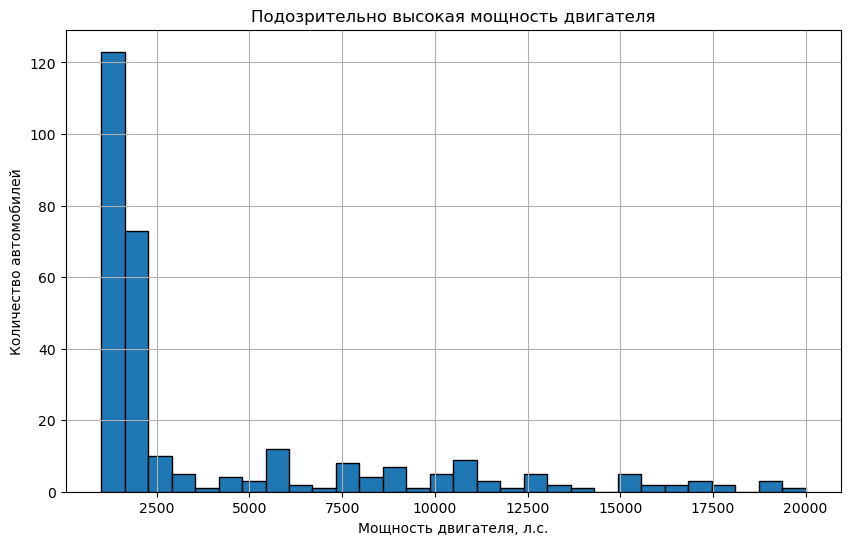

In [17]:
reg_power_mask = (df1['Power'] > 1000)
print(f'Количество объектов со слишком большой мощностью двигателя: {reg_power_mask.sum() / len(df1):.2%}')
df1[reg_power_mask]['Power'].hist(bins=30, edgecolor='black', figsize=(10, 6))
plt.title('Подозрительно высокая мощность двигателя')
plt.xlabel('Мощность двигателя, л.с.')
plt.ylabel('Количество автомобилей');

<div style="border:solid darkcyan 2px; padding: 20px; border-radius: 10px">

Вероятно, аномалии в мощности двигателя связаны с ошибкой в конвертации или вводе данных. Мощности у некоторых автомобилей увеличены в 10-100 раз. Но этих объектов очень мало (0.08%), поэтому просто удалим их.

In [18]:
df1 = df1.drop(df1[reg_power_mask].index)

<div style="border:solid darkcyan 2px; padding: 20px; border-radius: 10px">

В данных много объектов с мощностью равной нулю. Пользователи, вероятно, забыли заполнить это поле и по умолчанию оно стало нулём. Его можно заполнить так же, как пропущенные значения.

In [19]:
reg_power0_mask = (df1['Power'] == 0)
print(f'Количество объектов с нулевой мощностью двигателя: {reg_power0_mask.sum() / len(df1):.2%}')
df1[reg_power0_mask].head(3)

Количество объектов с нулевой мощностью двигателя: 11.07%


,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,sedan,manual,0,golf,150000,petrol,volkswagen,no
15,450,small,manual,0,ka,5000,petrol,ford,no
32,245,sedan,manual,0,golf,150000,petrol,volkswagen,no


Подберём для них значение мощности по соответствующим значениям других признаков.

In [20]:
power_group = df1.groupby(['Brand', 'Model', 'VehicleType', 'FuelType'])['Power'].mean()

# функция возвращает среднее значение мощности для данного типа объектов
# проверка на тип и модель автомобиля + тип топлива
def get_power(row):
    if row['Model'] in power_group[row['Brand']]:
        if row['VehicleType'] in power_group[row['Brand']][row['Model']]:
            if row['FuelType'] in power_group[row['Brand']][row['Model']][row['VehicleType']]:
                return power_group[row['Brand']][row['Model']][row['VehicleType']][row['FuelType']]
            else:
                return power_group[row['Brand']][row['Model']][row['VehicleType']].mean()
        else:
            return power_group[row['Brand']][row['Model']].mean()
    else:
        return power_group[row['Brand']].mean()

df1.loc[reg_power0_mask, 'Power'] = df1[reg_power0_mask].apply(get_power, axis=1).astype(int)

Удалим оставшиеся необработанными значения.

In [21]:
df1 = df1.drop(df1[df1['Power'] == 0].index)

#### 2.3.2 Price

В наборе данных присутствуют автомобили с нулевой ценой. Рассмотрим этот случай подробнее.

In [22]:
reg_price0_mask = (df1['Price'] == 0)
print(f'Количество объектов со нулевой ценой двигателя: {reg_price0_mask.sum() / len(df1):.2%}')
df1[reg_price0_mask].head(3)

Количество объектов со нулевой ценой двигателя: 2.91%


,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
7,0,sedan,manual,50,other,40000,petrol,volkswagen,no
40,0,small,manual,56,corsa,150000,petrol,opel,no
111,0,sedan,manual,92,golf,5000,petrol,volkswagen,no


<div style="border:solid darkcyan 2px; padding: 20px; border-radius: 10px">

Так как количество таких объектов невелико (2.82%), а обучать на нулевых значениях не имеет смысла, то просто удалим из набора эти объекты, чтобы не смещать прогноз.

In [23]:
df1 = df1[df1['Price'] != 0]

Рассмотрим структуру цен на гистограмме.

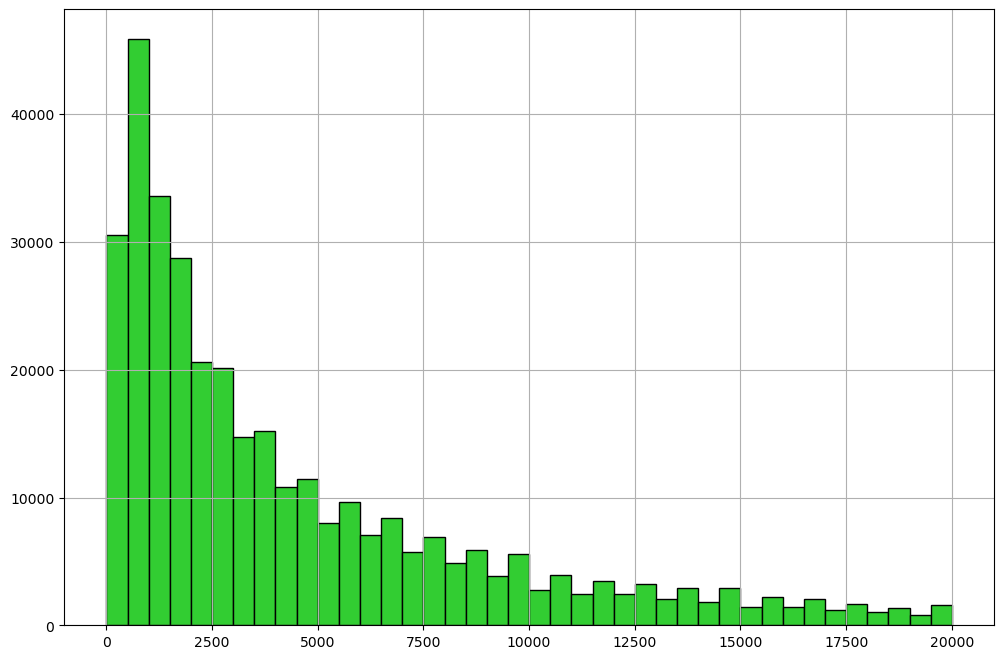

In [24]:
df1['Price'].hist(bins=40, color='limegreen', edgecolor='black', figsize=(12, 8));

### 2.4 Выводы 1

In [25]:
print('Результаты предобработки данных:')
print(f'Размер выборки: {df1.shape}')
print(f'Удалено объектов: {len(df) - len(df1)} ({(len(df) - len(df1)) / len(df):.2%})')
print(f'Количество пропусков в данных: {df1.isna().sum().sum()}')

Результаты предобработки данных:
Размер выборки: (340259, 9)
Удалено объектов: 14110 (3.98%)
Количество пропусков в данных: 0


<div style="border:solid darkcyan 2px; padding: 20px; border-radius: 10px">

Данные имеют не самое лучшее качество. Особенно информация о ремонте автомобилей, которая может сильно влиять на цену. Возможно, следует улучшить сбор данных от пользователей с целью уменьшения количества пропусков и некорректно введённой информации.

## 3. Обучение моделей

Так как "petrol" и "gasoline" - это по своей сути одно и то же, то приведём это к одному значению.

In [26]:
df1.loc[df1['FuelType'] == 'petrol', 'FuelType'] = 'gasoline'

In [27]:
df1['FuelType'].unique()

array(['gasoline', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

### 3.1 Разделение выборки

Разделим выборку на две части: обучающая и тестовая - 3:1.

In [28]:
features = df1.drop('Price', axis=1)
target = df1['Price']

X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size=0.25,
                                                    random_state=RSTATE)

print(f'Train features: {X_train.shape}')
print(f'Test  features: {X_test.shape}')
print(f'Train target:   {y_train.shape}')
print(f'Test  target:   {y_test.shape}')

Train features: (255194, 8)
Test  features: (85065, 8)
Train target:   (255194,)
Test  target:   (85065,)


### 3.2 Baseline

<div style="border:solid darkcyan 2px; padding: 15px; border-radius: 10px">  
    
* В качестве baseline-модели используем RandomForest с гиперпараметрами по умолчанию;
* Для неё нужно закодировать категориальные и ординальные признаки;
* Масштабировать числовые признаки нет необходимости, т.к. RandomForest нечувствительна к этому;
* Воспользуемся Pipeline для того, чтобы избежать утечек.    

Разделим данные по видам: ординальные, категориальные и числовые.

In [29]:
ord_features = ['Brand', 'Model']
cat_features = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired']
num_features = ['Power', 'Kilometer']

Бренд и модель автомобилей было решено кодировать ординально, чтобы не "раздувать" в ширину набор данных для обучения.

In [30]:
# кодирование признаков
ord_pipe = Pipeline([('ord_enc', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
cat_pipe = Pipeline([('cat_enc', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))])

# трансформер
col_trans = ColumnTransformer([('ordinal', ord_pipe, ord_features),
                               ('category', cat_pipe, cat_features)
                              ], remainder='passthrough', n_jobs=-1
                             )
# baseline-модель
baseline_model = RandomForestRegressor(random_state=RSTATE, n_jobs=-1)

# основной пайплайн
pipe = Pipeline([('column_transformer', col_trans),
                 ('reg', baseline_model)
                ])

In [31]:
cv_result = cross_validate(pipe, X_train, y_train, scoring='neg_root_mean_squared_error', 
                           cv=3, n_jobs=-1, return_estimator=True, error_score='raise')

In [32]:
baseline_feat_imp = pd.Series(cv_result['estimator'][1][1].feature_importances_,
                              index=cv_result['estimator'][1][0].get_feature_names_out()) \
                    .sort_values(ascending=False)

print(f'Baseline-модель: RMSE = {-cv_result["test_score"].mean().astype(int)}')
print(f'Важность признаков:\n{baseline_feat_imp}')

Baseline-модель: RMSE = 2285
Важность признаков:
remainder__Power                     0.466040
remainder__Kilometer                 0.259017
ordinal__Model                       0.105852
ordinal__Brand                       0.075222
category__Repaired_yes               0.022359
category__Gearbox_manual             0.014586
category__VehicleType_sedan          0.011176
category__VehicleType_convertible    0.009310
category__VehicleType_wagon          0.009264
category__VehicleType_suv            0.008908
category__VehicleType_coupe          0.006945
category__VehicleType_small          0.005322
category__FuelType_gasoline          0.001960
category__VehicleType_other          0.001779
category__FuelType_lpg               0.001457
category__FuelType_hybrid            0.000468
category__FuelType_electric          0.000285
category__FuelType_other             0.000049
dtype: float64


<div style="border:solid darkcyan 2px; padding: 15px; border-radius: 10px">  

* Самые важные признаки: мощность двигателя, пробег, модель, бренд;
* Больше половины признаков не являются важными для baseline-модели.

### 3.3 Обучение моделей

<div style="border:solid darkcyan 2px; padding: 20px; border-radius: 10px">
    
* В качестве моделей выбраны три бустинга: XGBoost, CatBoost и LightGBM;  
* Обучение будем проводить на кросс-валидации с подбором гиперпараметров GridSearchCV;  
* Все три модели позволяют напрямую подавать категориальные признаки.

Изменим исходыне типы категориальных данных на `category`.

In [34]:
X_train[ord_features + cat_features] = X_train[ord_features + cat_features].astype('category')
X_test[ord_features + cat_features] = X_test[ord_features + cat_features].astype('category')

#### 3.3.1 XGBoost

In [49]:
%%time
xgb_params = {'n_estimators': range(1, 201),
              'max_depth': range(1, 21),
              'max_leaves': range(1, 11),
              'learning_rate': np.arange(0.1, 0.51, 0.1)
             }

xgb_cv = RandomizedSearchCV(estimator=XGBRegressor(random_state=RSTATE, 
                                                   enable_categorical=True, 
                                                   n_jobs=-1),
                            param_distributions=xgb_params,
                            scoring='neg_root_mean_squared_error',
                            n_jobs=-1, cv=3,
                            n_iter=50,
                            random_state=RSTATE
                           )

xgb_cv.fit(X_train, y_train)

print(f'XGBoost: RMSE = {-xgb_cv.best_score_}\nпараметры = {xgb_cv.best_params_} ')

XGBoost: RMSE = 2416.8312103944004
параметры = {'n_estimators': 187, 'max_leaves': 8, 'max_depth': 3, 'learning_rate': 0.30000000000000004} 
CPU times: total: 18.9 s
Wall time: 1min 8s


#### 3.3.2 CatBoost

In [70]:
%%time
catb_params = {'n_estimators': range(1, 201),
               'max_depth': range(1, 17),
               'learning_rate': np.arange(0.1, 0.51, 0.1)
              }

catb_cv = RandomizedSearchCV(estimator=CatBoostRegressor(random_state=RSTATE, 
                                                         cat_features=ord_features + cat_features,
                                                         thread_count=-1,
                                                         verbose=0
                                                        ),
                             param_distributions=catb_params,
                             scoring='neg_root_mean_squared_error',
                             n_jobs=-1, cv=3,
                             n_iter=5,
                             random_state=RSTATE
                           )

catb_cv.fit(X_train, y_train)

print(f'CatBoost: RMSE = {-catb_cv.best_score_}\nпараметры = {catb_cv.best_params_} ')

CatBoost: RMSE = 2314.3787458791726
параметры = {'n_estimators': 86, 'max_depth': 13, 'learning_rate': 0.30000000000000004} 
CPU times: total: 1min 17s
Wall time: 1min 32s


#### 3.3.3 LightGBM

In [71]:
%%time
lgbm_params = {'n_estimators': range(1, 201),
              'max_depth': range(1, 21),
              'max_leaves': range(1, 11),
              'learning_rate': np.arange(0.1, 0.51, 0.1)
             }

lgbm_cv = RandomizedSearchCV(estimator=LGBMRegressor(random_state=RSTATE, 
                                                     verbose=-1,
                                                     n_jobs=-1),
                             param_distributions=lgbm_params,
                             scoring='neg_root_mean_squared_error',
                             n_jobs=-1, cv=3,
                             n_iter=50,
                             random_state=RSTATE
                            )

lgbm_cv.fit(X_train, y_train)

print(f'LightGBM: RMSE = {-lgbm_cv.best_score_}\nпараметры = {lgbm_cv.best_params_} ')

LightGBM: RMSE = 2239.1094179174293
параметры = {'n_estimators': 198, 'max_leaves': 1, 'max_depth': 17, 'learning_rate': 0.4} 
CPU times: total: 12.7 s
Wall time: 1min 35s


## 5. Анализ моделей

Сравним выбранные модели с лучшими найденными параметрами на соответствие критериям заказчика.

Создадим сводную таблицу с итогами обучения моделей.

In [99]:
pd.DataFrame([[xgb_cv.cv_results_['mean_fit_time'][xgb_cv.best_index_],   xgb_cv.cv_results_['mean_score_time'][xgb_cv.best_index_],   -xgb_cv.best_score_.round(1)],
              [catb_cv.cv_results_['mean_fit_time'][catb_cv.best_index_], catb_cv.cv_results_['mean_score_time'][catb_cv.best_index_], -catb_cv.best_score_.round(1)],
              [lgbm_cv.cv_results_['mean_fit_time'][lgbm_cv.best_index_], lgbm_cv.cv_results_['mean_score_time'][lgbm_cv.best_index_], -lgbm_cv.best_score_.round(1)]],
             index=['XGBoost', 'CatBoost', 'LightGBM'], columns=['Fit time, s', 'Predict time, s', 'RMSE']
            )

,"Fit time, s","Predict time, s",RMSE
XGBoost,6.226796,1.075422,2416.8
CatBoost,71.743472,0.099009,2314.4
LightGBM,10.781460,0.225687,2239.1


### 5.4 Выводы 2

<div style="border:solid darkcyan 2px; padding: 20px; border-radius: 10px">

* только у модели LightGBM качество выше (**RMSE = 2239**) чем у baseline-модели RandomForest, при этом она относительно быстро обучается;  
* две другие boosting-модели показали худшие результаты, а для лучшего результата требуется более прицельно подбирать гиперпараметры, что скажется на их производительности;
* исходя из требований заказчика для тестирования выбираем модель **LightGBM**.

## 6. Проверка лучшей модели

Проверим лучшую модель на тестовой выборке и оценим её качество.

In [100]:
print(f'Лучшая модель (LightGBM): RMSE = {mean_squared_error(y_test, lgbm_cv.best_estimator_.predict(X_test), squared=False)}')

Лучшая модель (LightGBM): RMSE = 2204.2649876771316


Оценим важность признаков в модели.

In [105]:
pd.Series(data=lgbm_cv.best_estimator_.feature_importances_, 
          index=lgbm_cv.best_estimator_.feature_name_).sort_values(ascending=False)

Power          2679
Model          1121
Kilometer      1109
Brand           398
VehicleType     291
Gearbox         208
Repaired        100
FuelType         34
dtype: int32

Оценим "вменяемость" модели, сравнив её dummy-моделью (среднее значение).

In [106]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_test, y_test)
print(f'Dummy-модель: RMSE = {mean_squared_error(y_test, dummy_model.predict(X_test), squared=False)}')

Dummy-модель: RMSE = 4496.538312345142


## 7. Выводы

<div style="border:solid darkcyan 2px; padding: 20px; border-radius: 10px">

1. Данные оказались не самого высокого качества: у части автомобилей отсутствуют значимые данные (мощность, ремонт), присутствует большое число аномалий. Всё это связано, вероятно, со способом ввода и обработки данных. Стоит ввести проверку вводимой информации для улучшения качества исходных данных. Часть пропущенных значений и аномалий была обработана, чтобы и сохранить данные и не ухудшить качество моделей.  
2. Данные были разделены и признаки были закодированы.  
3. Выбраны три boosting-модели: XGBoost, CatBoost и LightGBM. Методом кросс-валидации были найдены лучшие параметры для них.  
4. Модели были обучены, проведено их сравнение на соответствие требованиям заказчика (время обучения, время прогнозирования, качество).  
5. Лучшая модель - **LightGBM** с гиперпараметрами: **n_estimators = 198**, **max_leaves = 1**, **max_depth = 17**, **learning_rate = 0.4**. Метрика качества на тестовой выборке **RMSE = 2204**.  
6. В лучшей модели наиболее важными признаками стали: мощность двигателя, бренд и модель автомобиля, пробег.